In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,IPython, librosa, mir_eval
from sys import platform
from os import listdir
from os.path import isfile, join,isdir
from IPython.display import Audio
from librosa.display import waveplot,specshow
from librosa.onset import onset_strength, onset_detect
from librosa.feature import melspectrogram, mfcc
from librosa import load

from collections import defaultdict,OrderedDict
import sklearn
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scipy
from pandas import HDFStore,DataFrame



# Song Extraction from fma_small

1. Find the song folder path relative to the current computer
2. Retrieve the different genre classifications
3. Identify each song via its full path to song using index, to guarantee one-to-one mapping 
4. Sort in alphabetical order

In [2]:
#retrieving path to the fma_small directory and the corresponding meta data
HOME_DIR = IPython.utils.path.get_home_dir()

temp = join(HOME_DIR, 'Documents')
path_to_small_fma = join(temp, 'fma_small')
json_file = join(path_to_small_fma,'fma_small.json')
#locate meta_dta
print(path_to_small_fma)
df = pd.read_json(json_file)
print(json_file)


/home/chib/Documents/fma_small
/home/chib/Documents/fma_small/fma_small.json


In [3]:
#only choose top genre as the label
df = df.loc[:,['top_genre']]

#ensure that the genre name matches file name in fma_small, 
#i.e Oldtime / Historian conflict issue
df['top_genre']=df['top_genre'].apply(lambda y: y.split(os.sep)[0].strip())
#locate each individual song by its full path
df['temp'] = path_to_small_fma
str_index = ["%.2d" % x for x in df.index]
complete_genre_list = df['top_genre'].unique()

#create full path to file and store as a single array
df['full_path_to_song'] = df.temp.map(str)+ "/"+ df['top_genre'].values+ "/"+ str_index+ ".mp3"
del df['temp']
#keep songs according to alphabetical order of songs 
df.sort_values(by = 'top_genre', inplace = True)
df.head()


,top_genre,full_path_to_song
100538,Electronic,/home/chib/Documents/fma_small/Electronic/1005...
43206,Electronic,/home/chib/Documents/fma_small/Electronic/4320...
43199,Electronic,/home/chib/Documents/fma_small/Electronic/4319...
43153,Electronic,/home/chib/Documents/fma_small/Electronic/4315...
43124,Electronic,/home/chib/Documents/fma_small/Electronic/4312...


In [4]:
complete_genre_list_df = pd.DataFrame(complete_genre_list, columns = ['Genre'])

In [5]:
#retrieve number of songs per genre
genre_and_count = df['top_genre'].value_counts().sort_index()
all_songs_path = df['full_path_to_song'].values  
print(genre_and_count)

Electronic    400
Folk          400
Hip-Hop       400
Indie-Rock    400
Jazz          400
Old-Time      400
Pop           400
Psych-Rock    400
Punk          400
Rock          400
Name: top_genre, dtype: int64


In [6]:
song_counts = [] 
ordered_genres = [] 
full_song_df = OrderedDict()
genre_to_song_dict = {}


#retrieve number of songs per genre with the order preserved in two lists
#ordered_genres
#song_counts
for i,genre in enumerate(genre_and_count.index):
    ordered_genres.append(genre)
    temp = df['top_genre'].value_counts()[genre]
    song_counts.append(temp)

genre_to_song_zipped = zip(ordered_genres,song_counts)

num_of_genre = np.shape(genre_and_count)[0]
print("The number of genres is:", num_of_genre)

#dictionary with each song count and its corresponding genre
for genre,song_count in genre_to_song_zipped:
    genre_to_song_dict[genre] = song_count

genre_to_song_dict

The number of genres is: 10


{'Electronic': 400,
 'Folk': 400,
 'Hip-Hop': 400,
 'Indie-Rock': 400,
 'Jazz': 400,
 'Old-Time': 400,
 'Pop': 400,
 'Psych-Rock': 400,
 'Punk': 400,
 'Rock': 400}

In [7]:
num_of_genre = np.shape(genre_and_count)[0]
all_songs_path = df['full_path_to_song'].values

paths_dict = OrderedDict()

#prepend zero so we have a start point for all_songs_path 
#and avoid messing with indices

#use the cumulative sum to find none uniform ranges
song_counts.insert(0,0)
cumulative_sum = np.cumsum(song_counts,dtype=int)

#creates a dictionary of the genres and its corresponding path
for i,genre in enumerate(ordered_genres):
    str1=genre
    str2 = "_paths"
    genre_paths = "".join((str1,str2))
    paths_dict[genre_paths] = all_songs_path[cumulative_sum[i]:cumulative_sum[i+1]]

#paths_dict
#{genre_path_name: genre_paths}
print("{'Electronic_paths:[array_of_all_electronic_paths]}")

{'Electronic_paths:[array_of_all_electronic_paths]}


In [8]:
%%time
num_of_songs = 3
sampling_rate = 44100

genre_signals_dict = OrderedDict()
#creates a dictionary of the signals in a genre and their raw file
for genre_path_name,genre_paths in paths_dict.items():
    str1=genre_path_name[:-5]
    str2 = "signals"
    genre_signals = "".join((str1,str2))       
    try:
        first_three = genre_paths[:num_of_songs]
        genre_signals_dict[genre_signals] = [
        load(p,sr=None)[0] for p in first_three]
    except IOError as exc:
        print("Unable to locate folder")
        #raise IOError("%s: %s" % (genre_paths, exc.strerror))
        
#genre_signals_dict
#{genre_signals_name:genre_signals_paths}
print("{'Electronic_signals:[array_of_all_electronic_paths]}")

{'Electronic_signals:[array_of_all_electronic_paths]}
CPU times: user 2.81 s, sys: 1.09 s, total: 3.9 s
Wall time: 6.8 s


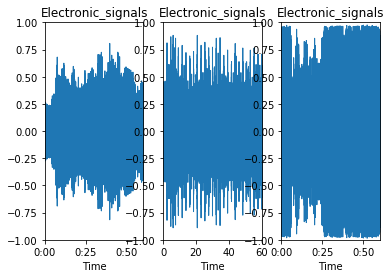

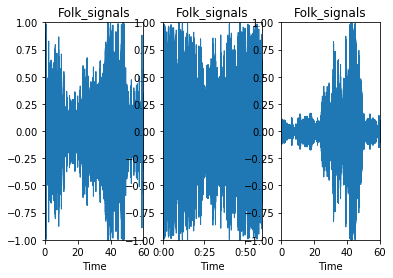

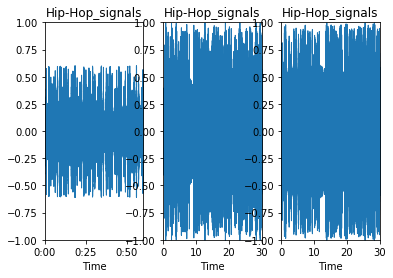

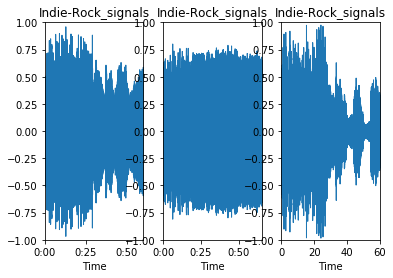

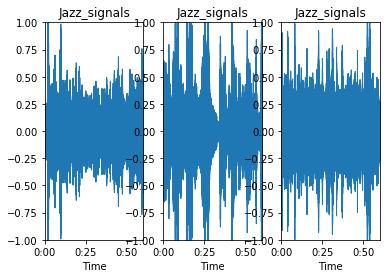

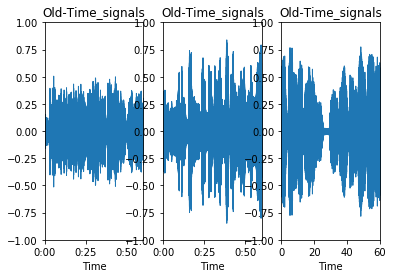

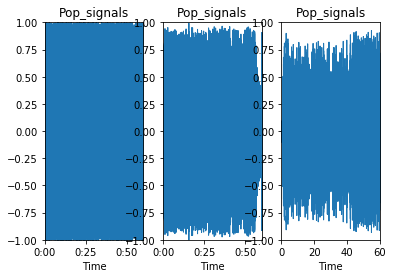

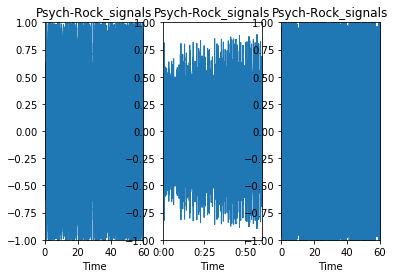

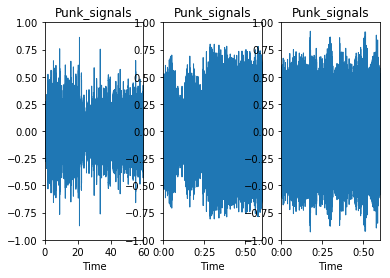

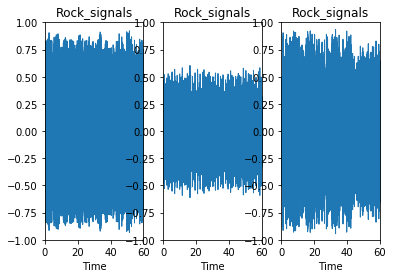

In [9]:
#plot the time series for each song according to the genres

#sig_lengths = []
for genre_signal_name,genre_signals in genre_signals_dict.items(): 
    for i, sig_amp in enumerate(genre_signals):
        plt.subplot(1, num_of_songs, i+1)
#        sig_lengths.append(len(sig_amp))
        waveplot(sig_amp)
        plt.ylim(-1, 1)
        plt.title(genre_signal_name)
    plt.figure()
        
    

## Testing the complete feature extraction on a single song

In [10]:
pwd

'/home/chib/Documents/ChibuSemesterProject/fma-baselines'

In [37]:
#home laptop
if "Ubuntu" in os.uname().version:
    song, sampling_rate = librosa.load("/home/chib/Documents/fma_small/Electronic/99289.mp3")

#lab macbook
elif "Darwin" in os.uname().version:
    song, sampling_rate = librosa.load("/Users/chibmac/Documents/fma_small/Electronic/99289.mp3")

else: 
    song, sampling_rate = librosa.load(librosa.util.example_audio_file())
    
song.shape


(660984,)

In [38]:
num_of_mfcc = 12

In [39]:
num_of_frames = int(np.floor((len(song)*4)/2048))
num_of_frames

1290

In [40]:
#should be a factor of the number of frames
factor_list = []
for i in range(1,10):
    if (num_of_frames%i == 0) :
        factor_list.append(i)
num_of_segments = factor_list[-1]
print("Number of segments: %d"% num_of_segments)
factor_list

Number of segments: 6


[1, 2, 3, 5, 6]

In [41]:
num_of_frames_per_segment = int(num_of_frames/num_of_segments)
num_of_frames_per_segment

215

In [42]:
#2048 is default for n_fft
#4 as hopsize is 2048/4
song_f = song[:int((num_of_frames*2048/4) -1)] 
song_t = song[:int(num_of_frames*2048/4)] 
ind_song_into_segment = int(len(song_t)/num_of_segments)
song_into_segments = np.reshape(song_t,(num_of_segments,ind_song_into_segment))
song_into_segments.shape


(6, 110080)

# Time Domain Features
- 
## Zero Crossing Rate (ZCR) 
- 
## Onsets 


In [43]:
zcr_per_segment = np.sum(librosa.core.zero_crossings(song_into_segments),axis = 1) #zero crossings returns boolean values
zcr_per_segment = np.reshape(zcr_per_segment,(zcr_per_segment.shape[0],1))
for i in range (len(factor_list)+1):
    print("Segment number %d: has %d zero crossings"%(i+1,zcr_per_segment[i]))

zcr_per_segment.shape

Segment number 1: has 8059 zero crossings
Segment number 2: has 9050 zero crossings
Segment number 3: has 10114 zero crossings
Segment number 4: has 11070 zero crossings
Segment number 5: has 12419 zero crossings
Segment number 6: has 12633 zero crossings


(6, 1)

In [44]:
onset_frames = librosa.onset.onset_detect(y=song_t, sr=sampling_rate, units='samples')
onset_length = len(onset_frames)
onset_frames

array([  1536,   5120,   6144,   7680,  11264,  14336,  17920,  20480,
        23552,  27136,  30208,  33280,  36864,  39936,  43520,  46080,
        49664,  52736,  56320,  58880,  62464,  65536,  71680,  75776,
        78336,  84992,  91136,  97280, 100864, 103936, 110592, 113664,
       120320, 122880, 126976, 130560, 136704, 142848, 148992, 152576,
       155648, 158720, 162304, 165376, 168448, 174080, 177664, 182784,
       187904, 192512, 194048, 198656, 204288, 206848, 210432, 213504,
       217088, 219648, 226304, 229376, 232448, 236032, 239104, 245248,
       248832, 251904, 254976, 258048, 264704, 268288, 274944, 283648,
       296960, 303104, 309760, 316416, 319488, 322560, 328704, 335360,
       341504, 348160, 354816, 360960, 367616, 370688, 373760, 380416,
       386560, 393216, 399360, 406016, 412160, 418816, 422400, 424448,
       425472, 431616, 435200, 438272, 444416, 451072, 457216, 463872,
       470528, 474112, 476672, 482816, 489472, 495616, 502272, 508928,
      

In [45]:
song_splitter = np.arange(0,len(song_t)+1, ind_song_into_segment,dtype=int)
split_length = len(song_splitter)
song_splitter

array([     0, 110080, 220160, 330240, 440320, 550400, 660480])

In [46]:
total_onsets = [0]
for i in range(1,len(song_splitter)):
    total_onsets.append(np.sum(onset_frames<song_splitter[i]))

total_onsets

[0, 30, 58, 79, 100, 119, 138]

In [47]:
total_onset_diff = np.diff(total_onsets)
onsets_per_segment = np.reshape(total_onset_diff,(len(total_onset_diff),1))
for i in range (len(factor_list)+1):
    print("Segment number %d: has %d onsets"%(i+1,onsets_per_segment[i]))

onsets_per_segment.shape

Segment number 1: has 30 onsets
Segment number 2: has 28 onsets
Segment number 3: has 21 onsets
Segment number 4: has 21 onsets
Segment number 5: has 19 onsets
Segment number 6: has 19 onsets


(6, 1)

# Frequency Domain Features
- 
## MFCC 
- 
## Spectral Centroid



In [48]:
mfcc_per_segment = librosa.feature.mfcc(y=song_f, sr=sampling_rate,
                                     n_mfcc=num_of_mfcc).T
print("The number of frames is %d" % mfcc_per_segment.shape[0])
mfcc_per_segment = np.reshape(mfcc_per_segment,(num_of_segments,num_of_frames_per_segment,num_of_mfcc))
mps_seg,mps_fps,mps_mfccs = mfcc_per_segment.shape

print("Number of Segments: %d, Number of frames per segment: %d, Number of mfccs:%d" %(mps_seg,mps_fps, mps_mfccs))  

mfcc_per_segment.shape


The number of frames is 1290
Number of Segments: 6, Number of frames per segment: 215, Number of mfccs:12


(6, 215, 12)

In [49]:
mean_mfcc_per_segment = np.mean(mfcc_per_segment,axis=1)
mean_mfcc_per_segment = np.reshape(mean_mfcc_per_segment,(mean_mfcc_per_segment.shape[0],1,mean_mfcc_per_segment.shape[1]))
var_mfcc_per_segment = np.var(mfcc_per_segment,axis =1)
var_mfcc_per_segment = np.reshape(var_mfcc_per_segment,(var_mfcc_per_segment.shape[0],1,var_mfcc_per_segment.shape[1]))
skew_mfcc_per_segment = scipy.stats.skew(mfcc_per_segment,axis =1)
skew_mfcc_per_segment = np.reshape(skew_mfcc_per_segment,(skew_mfcc_per_segment.shape[0],1,skew_mfcc_per_segment.shape[1]))
kurtosis_mfcc_per_segment = scipy.stats.kurtosis(mfcc_per_segment,axis =1)
kurtosis_mfcc_per_segment = np.reshape(kurtosis_mfcc_per_segment,(kurtosis_mfcc_per_segment.shape[0],1,kurtosis_mfcc_per_segment.shape[1]))


In [50]:
mfcc_features_per_segment = np.concatenate((mean_mfcc_per_segment,var_mfcc_per_segment,skew_mfcc_per_segment,kurtosis_mfcc_per_segment),axis = 1)

mfcc_features_per_segment.shape

(6, 4, 12)

In [51]:
spectral_centroid = librosa.feature.spectral_centroid(y=song_f, sr=sampling_rate).T
print(spectral_centroid.shape)
spc_per_segment = np.reshape(spectral_centroid, (num_of_segments,num_of_frames_per_segment))
spc_per_segment.shape
#mean_spc_per_segment.shape

(1290, 1)


(6, 215)

In [52]:
mean_spc_per_segment = np.mean(spc_per_segment,axis=1)
mean_spc_per_segment = np.reshape(mean_spc_per_segment,(len(mean_spc_per_segment),1))
var_spc_per_segment = np.var(spc_per_segment,axis =1)
var_spc_per_segment = np.reshape(var_spc_per_segment,(len(var_spc_per_segment),1))
skew_spc_per_segment = scipy.stats.skew(spc_per_segment,axis =1)
skew_spc_per_segment = np.reshape(skew_spc_per_segment,(len(skew_spc_per_segment),1))
kurtosis_spc_per_segment = scipy.stats.kurtosis(spc_per_segment,axis =1)
kurtosis_spc_per_segment = np.reshape(kurtosis_spc_per_segment,(len(kurtosis_spc_per_segment),1))

mean_spc_per_segment.shape

(6, 1)

In [53]:
spc_features_per_segment = np.concatenate((mean_spc_per_segment,var_spc_per_segment,skew_spc_per_segment,kurtosis_spc_per_segment),axis = 1)

spc_features_per_segment.shape

(6, 4)

In [54]:
mfcc_features_per_segment.shape

(6, 4, 12)

In [55]:
spc_features_per_segment.shape

(6, 4)

In [56]:
zcr_per_segment.shape

(6, 1)

In [57]:
onsets_per_segment.shape

(6, 1)

In [ ]:
features_per_section = np.concatenate((mfcc_features_per_segment, spc_features_per_segment, zcr_per_segment, onsets_per_segment),axis =3)

fps_song,fps_sect,fps_hops,fps_per_hop= features_per_section.shape

features_per_section.shape

In [ ]:
print("MFCC Per section: ",mfcc_per_section.shape,"ZCR per section:",zcr_per_section.shape,
      "SPC Per section: ",spectral_centroid_per_section.shape,"Onsets Per section: ",onsets_per_section.shape,
      "AC global Per section: ",ac_global.shape
     )

In [ ]:
features_per_section = np.concatenate((mfcc_per_section,zcr_per_section,onsets_per_section,spectral_centroid_per_section,ac_global),axis =3)

fps_song,fps_sect,fps_hops,fps_per_hop= features_per_section.shape

features_per_section.shape

In [ ]:
features_per_section = np.reshape(features_per_section,(1,1,fps_hops*fps_per_hop))
features_per_section.shape

In [ ]:
def complete_extract_features(song,num_of_sections,num_of_hops_per_section,num_of_mfcc,num_of_features,genre):
    total_num_of_features = (num_of_features-1 + num_of_mfcc)* num_of_hops_per_section
    song_length = len(song)
    tot_num_of_hops = num_of_hops_per_section*num_of_sections
    hop_width = int(np.floor(song_length/tot_num_of_hops))
    section_width = hop_width*num_of_hops_per_section
    song = song[:(hop_width*tot_num_of_hops)]
    section_per_song = np.reshape(song,(1,num_of_sections,section_width))
    sps_song,sps_sect,sps_width =  section_per_song.shape
    
    #print(section_per_song.shape)
    try:
        for i in range(sps_sect):
            #print(i)
            complete_n_fft = hop_width+1
            one_song_section =section_per_song[0,i,:]
            one_song_section = np.reshape(one_song_section,(1,1,one_song_section.shape[0]))
            #print(one_song_section.shape)
            hop_per_section = np.reshape(one_song_section,(1,1,num_of_hops_per_section,hop_width))
            #print(hop_per_section.shape)
            one_song_section_squeezed = np.squeeze(one_song_section)
            #print(one_song_section_squeezed.shape)

            mfcc_per_section = librosa.feature.mfcc(y=one_song_section_squeezed, sr=sampling_rate,
                                        n_fft = complete_n_fft, n_mfcc=num_of_mfcc,hop_length = hop_width).T
            mfcc_per_section = np.reshape(mfcc_per_section,(1,1,mfcc_per_section.shape[0],mfcc_per_section.shape[1]))
            #print("mfcc",mfcc_per_section.shape)
            zcr_per_section = np.sum(librosa.core.zero_crossings(np.squeeze(hop_per_section)),axis =1 )
            #print(zcr_per_section.shape)
            zcr_per_section= np.reshape(zcr_per_section,(1,1,len(zcr_per_section),1))
            #print("zcr",zcr_per_section.shape)
            onset_frames = librosa.onset.onset_detect(y=one_song_section_squeezed, sr=sampling_rate,units = 'samples')
            song_splitter = np.arange(0,len(one_song_section_squeezed)+1, hop_width,dtype=int)
            total_onsets = [0]
            for j in range(1,len(song_splitter)):
                total_onsets.append(np.sum(onset_frames<song_splitter[j]))
            onsets_per_section = np.reshape(np.diff(total_onsets),(1,1,len(np.diff(total_onsets)),1))
            #print("onset",onsets_per_section.shape)
            spectral_centroid_per_section = librosa.feature.spectral_centroid(y=one_song_section_squeezed, sr=sampling_rate, hop_length= hop_width,n_fft=complete_n_fft).T
            spectral_centroid_per_section = np.reshape(spectral_centroid_per_section,(one_song_section.shape[0],one_song_section.shape[1],spectral_centroid_per_section.shape[0],spectral_centroid_per_section.shape[1]))
            #print("spectral centroid",spectral_centroid_per_section.shape)
            #oenv = librosa.onset.onset_strength(y=one_song_section_squeezed, sr=sampling_rate, hop_length=hop_width, n_fft = (2*hop_width))
            #tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sampling_rate,
            #                              hop_length=hop_width)
            #ac_global_temp = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
            #ac_global = np.reshape(ac_global_temp, (one_song_section.shape[0],one_song_section.shape[1],len(ac_global_temp),1))
            #print("ac glob",ac_global.shape)
            feats_per_section = np.concatenate((mfcc_per_section,zcr_per_section,onsets_per_section,spectral_centroid_per_section),axis =3)
            fps_song,fps_sect,fps_hops,fps_per_hop= feats_per_section.shape
            #print("fps",feats_per_section.shape)
            feats_per_section = np.reshape(feats_per_section,(1,1,fps_hops*fps_per_hop))
            feats_per_section= np.squeeze(feats_per_section,axis = 0)
            #print()

    except:
        feats_per_section = np.zeros((1,total_num_of_features))
        print("There was an error whilst computing the features")
    return feats_per_section
    

In [ ]:
test_out = complete_extract_features(song,num_of_sections,num_of_hops_per_section,num_of_mfcc,num_of_features,10)

test_out.shape


## Generalisation of feature extraction for all the songs in the fma_small dataset


In [ ]:
song_num = 0
tot_num_of_songs = cumulative_sum[-1]
indiv_song_path= []
for genre_path_name,genre_paths in paths_dict.items(): 
    song_num=song_num+1
    indiv_song_path.append(genre_paths)
  

indiv_song_path_list = np.array(indiv_song_path).reshape(tot_num_of_songs,)

In [ ]:
indiv_song_path_list


In [ ]:
genres = []
for song_num in range(len(indiv_song_path_list)):
    temp = indiv_song_path_list[song_num].split(os.sep)[-2]
    genres.append(temp)
        

In [ ]:
le = LabelEncoder()
encoded_genres= le.fit(genres)
encoded_genres

#Label Encoding Mapping
encoder_df= pd.DataFrame(data= {'Genre':genres,
                   'Encoded_Genre':le.transform(genres)})
encoder_df.head()

In [ ]:
print("I AM HERE")

In [ ]:
%%time

tot_num_of_songs = cumulative_sum[-1]
final_d = np.zeros((tot_num_of_songs,test_out.shape[1]))
print(final_d.shape)

for song_num in range(len(indiv_song_path_list)):
    try:
        indiv_song_path = indiv_song_path_list[song_num]
        song_signal = librosa.load(indiv_song_path,sr=None)[0]
        curr_song_genre = encoder_df['Encoded_Genre'][song_num]
        final_d[song_num]= complete_extract_features(song_signal,num_of_sections,num_of_hops_per_section,num_of_mfcc,num_of_features,curr_song_genre)
                
        print(complete_extract_features(song_signal,num_of_sections,num_of_hops_per_section,num_of_mfcc,num_of_features,curr_song_genre).shape)
        
        
        
    except IOError as exc:
        print("Unable to locate folder")
    


            

In [ ]:
final_d.shape

In [ ]:
print("I AM HERE")

In [ ]:

complete_df = pd.DataFrame(data=final_d.T,index =range(final_d.shape[1]))
complete_df = complete_df.T

complete_df.head()

In [ ]:
complete_df.shape

In [ ]:
encoder_df.head()

In [ ]:
encoder_df.shape

In [ ]:
final_df = pd.concat([complete_df,encoder_df],axis =1)
final_df.head()


In [ ]:
final_df.shape

In [ ]:
final_df.to_csv("FullSongFeatureExtraction28.csv",sep=',')